In [1]:
import os
import numpy as np
import pandas as pd
import sys

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import xgboost as xgb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sys.path.append(os.path.dirname(os.getcwd()))
from tools.utils import PERIODIC_TABLE_INFO, PTC_COLNAMES, encode_all_structures, Encoding

In [2]:
DATA_DIR = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())), "data/"
)

# Loading Data

In [3]:
encoding = Encoding.COLUMN_MASS

df = pd.read_csv(os.path.join(DATA_DIR, "data.csv"), index_col=0, na_filter= False)
df = encode_all_structures(df, encoding)

In [4]:
cols_raw = list(df.columns)
cols_trash = ["structure", 'converged', 'accuracy', "n_iterations", "time", "fermi", "total_energy"]
cols_independent = ['delta_E']
cols_drop = cols_trash + cols_independent

cols_dependent = cols_raw.copy()
for element in cols_drop:
    cols_dependent.remove(element)

In [5]:
X_raw = df[cols_dependent][df["converged"]]
y_raw = np.abs(df[cols_independent][df["converged"]]).squeeze()

In [6]:
X_raw.describe()

,ecutrho,k_density,ecutwfc,Lant,PTC1,PTC2,PTC3,PTC4,PTC5,PTC6,...,PTC9,PTC10,PTC11,PTC12,PTC13,PTC14,PTC15,PTC16,PTC17,PTC18
count,62458.000000,62458.000000,62458.000000,62458.000000,62458.000000,62458.000000,62458.000000,62458.000000,62458.000000,62458.000000,...,62458.000000,62458.000000,62458.000000,62458.000000,62458.000000,62458.000000,62458.000000,62458.000000,62458.000000,62458.0
mean,244.912101,5.856063,58.431266,0.148408,0.030426,0.041234,0.020184,0.021552,0.028327,0.014276,...,0.063783,0.055349,0.064660,0.046991,0.050979,0.044910,0.094091,0.061162,0.022155,0.0
std,89.243957,2.832946,24.204293,0.285161,0.130828,0.128356,0.102080,0.102914,0.117325,0.090289,...,0.197564,0.185805,0.191193,0.165755,0.164559,0.132338,0.213313,0.166961,0.121754,0.0
min,100.000000,2.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,180.000000,4.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,260.000000,6.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,340.000000,8.000000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,380.000000,10.000000,100.000000,0.924714,0.733997,0.732088,0.741626,0.841555,0.885522,0.783026,...,0.876908,0.983118,0.899810,0.862178,0.967155,0.808676,0.918451,0.839999,0.833172,0.0


# Train-Test-Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    random_state=42
)

# Model definitions

### Linear Model with feature augmentation

In [8]:
# functions such that f(x) != 0 and f(+inf) = 0
functions_set_1 = [
    lambda x: np.exp(-x),
    lambda x: 1 / (1+x),
    lambda x: 1 / (1+x)**2,
    lambda x: np.cos(x) * np.exp(-x),
]

# functions such that f(x) = 0 and f(+inf) = 0
functions_set_2 = [
    lambda x: x*np.exp(-x),
    lambda x: x / (1+x)**2,
    lambda x: x / (1+x)**3,
    lambda x: np.sin(x) * np.exp(-x),
]

linear_augmented_model = Pipeline([
    ('scaler_init', StandardScaler()),
    ('features', FeatureUnion(
    [
        (f"fun_{j}", FunctionTransformer(lambda X : f(X[:,:3]))) for j, f in enumerate(functions_set_1 + functions_set_2)
    ] + [
        (f"fun_{j}_col_{col}_1", FunctionTransformer(lambda X : f(X[:,:3] * X[:,i][:, None]))) for j, f in enumerate(functions_set_1) for i, col in enumerate(["ecutrho", "kpoints", "ecutwfc"])
    ] + [
        (f"fun_{j}_col_{col}_2", FunctionTransformer(lambda X : f(X[:,3:] * X[:,i][:, None]))) for j, f in enumerate(functions_set_2) for i, col in enumerate(["ecutrho", "kpoints", "ecutwfc"])
    ])),
    ('scaler_final', StandardScaler()),
    ('regressor', LinearRegression()),
])

### Random forest

In [9]:
rf_model = RandomForestRegressor(random_state=0)

### Gradient Boosting

In [10]:
gb_model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

### XGBoost

In [11]:
xgb_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0, tree_method="gpu_hist")

### Packing them together to reduce code size

In [12]:
models = {
    "Augmented Linear Regression": linear_augmented_model,
    "Random Forest": rf_model,
    # "Gradient Boosting": gb_model,
    "XGBoost": xgb_model,
}

# Model training

In [13]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print("Done!\n")

Training Augmented Linear Regression...
Done!

Training Random Forest...
Done!

Training XGBoost...
Done!



# Model evaluation

In [14]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Augmented Linear Regression...
MSE:	train:3.4071E-02	test:3.5432E-02
MAPE:	train:1.6691E+11	test:2.9540E+11
Done!

Evaluating Random Forest...
MSE:	train:1.5678E-06	test:7.0540E-06
MAPE:	train:4.1848E+08	test:1.3518E+08
Done!

Evaluating XGBoost...
MSE:	train:6.2121E-06	test:9.0221E-06
MAPE:	train:5.4484E+09	test:4.7109E+09
Done!



# Visualization

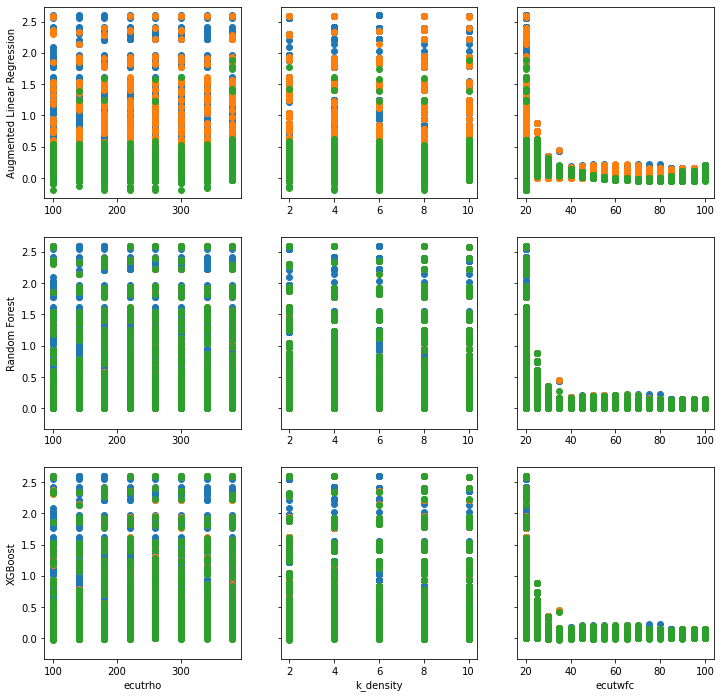

In [15]:
n_models = len(models)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], y_train)
        ax[j,i].scatter(X_test[col], y_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')
PLOTPATH = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "plots/delta_E_regression/toy_comparison.png")
plt.savefig(PLOTPATH)

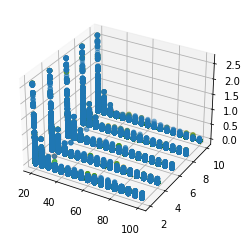

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['ecutwfc'], X_train['k_density'], y_train)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], y_test)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], rf_model.predict(X_test))

## Predict $\log(\Delta E)$ instead of $∆E$

In [17]:
class LogTransform:
    def __init__(self, y):
        self.miny = float(np.min(y))
        miny2 = np.sort(list(set(list(np.array(y.squeeze())))))[1]
        print(self.miny, miny2)
        self.eps = (miny2 - self.miny)/10

    def transform(self, y):
        return np.log(y - self.miny + self.eps)
        
    def inverse_transform(self, logy):
        return np.exp(logy) + self.miny - self.eps

log_transform = LogTransform(y_raw)

logy_raw = log_transform.transform(y_raw)
X_train, X_test, logy_train, logy_test = train_test_split(
    X_raw, logy_raw,
    test_size=0.2,
    random_state=42
)

0.0 5.000003966415534e-09


Text(0.5, 1.0, 'Log')

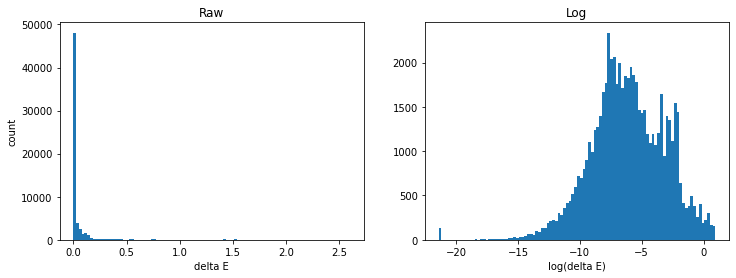

In [18]:
# plot hist of y_raw and logy_raw
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].set_ylabel("count")
ax[0].hist(y_raw, bins=100)
ax[0].set_xlabel("delta E")
ax[0].set_title("Raw")
ax[1].hist(logy_raw, bins=100)
ax[1].set_xlabel("log(delta E)")
ax[1].set_title("Log")

In [19]:
linear_log_augmented_model = Pipeline([
    ('scaler_init', StandardScaler()),
    ('features', PolynomialFeatures(degree=2)),
    ('scaler_final', StandardScaler()),
    ('regressor', LinearRegression()),
])

In [20]:
rf_log_model = RandomForestRegressor()

In [21]:
gb_log_model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

In [22]:
xgb_log_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0, tree_method="gpu_hist")

In [23]:
models_log = {
    "Augmented Linear Regression - Log": linear_log_augmented_model,
    "Random Forest - Log": rf_log_model,
    # "Gradient Boosting - Log": gb_log_model,
    "XGBoost - Log": xgb_log_model,
}

In [24]:
for model_name, model in models_log.items():
    print(f"Training {model_name}...")
    model.fit(X_train, logy_train)
    print("Done!\n")

Training Augmented Linear Regression - Log...
Done!

Training Random Forest - Log...
Done!

Training XGBoost - Log...
Done!



In [25]:
for model_name, model in models_log.items():
    print(f"Evaluating {model_name}...")

    logy_pred_train = model.predict(X_train)
    y_pred_train = log_transform.inverse_transform(logy_pred_train.squeeze())
    logy_pred_test = model.predict(X_test)
    y_pred_test = log_transform.inverse_transform(logy_pred_test.squeeze())
    
    y_train = log_transform.inverse_transform(logy_train.squeeze())
    y_test = log_transform.inverse_transform(logy_test.squeeze())

    mse_test = mean_squared_error(logy_test, logy_pred_test)
    mse_train = mean_squared_error(logy_train, logy_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")
    
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mape_test = mean_absolute_percentage_error(logy_test, logy_pred_test)
    mape_train = mean_absolute_percentage_error(logy_train, logy_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Augmented Linear Regression - Log...
MSE:	train:2.4982E+00	test:2.5385E+00
MSE:	train:2.9923E-02	test:2.9900E-02
MAPE:	train:4.4309E-01	test:4.2936E-01
Done!

Evaluating Random Forest - Log...
MSE:	train:2.7687E-02	test:1.6911E-01
MSE:	train:8.7149E-06	test:1.6879E-05
MAPE:	train:4.7882E-03	test:1.2283E-02
Done!

Evaluating XGBoost - Log...
MSE:	train:4.6400E-02	test:1.9972E-01
MSE:	train:1.6867E-04	test:2.7021E-04
MAPE:	train:2.2576E-02	test:3.1122E-02
Done!



Text(0.5, 0, 'ecutwfc')

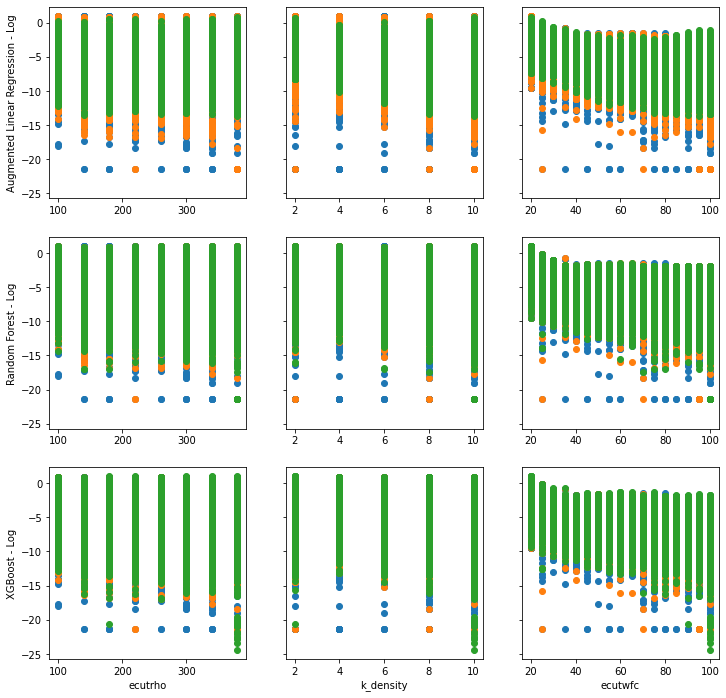

In [26]:
n_models_log = len(models_log)
fig, ax = plt.subplots(n_models_log,3,figsize=(12,4*n_models_log), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models_log.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], logy_train)
        ax[j,i].scatter(X_test[col], logy_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')

# Analysing models

## Plot feature importance

### $\Delta E$

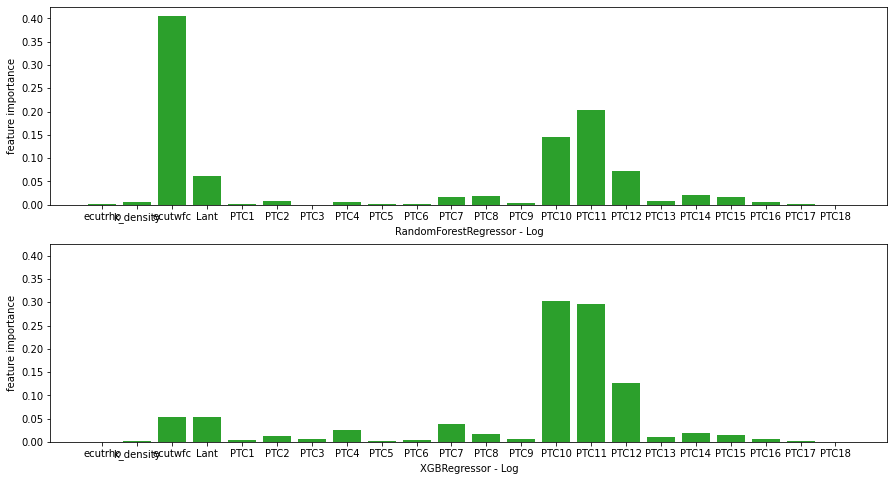

In [27]:
# plot feature importance
models_feature_importance = {
    "RandomForestRegressor - Log": rf_model,
    "XGBRegressor - Log": xgb_model,
}
n_models = len(models_feature_importance)
fig, ax = plt.subplots(n_models, 1,figsize=(15,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models_feature_importance.items()):
    ax[j,0].bar(X_train.columns, model.feature_importances_)
    ax[j,0].bar(X_test.columns, model.feature_importances_)
    ax[j,0].bar(X_test.columns, model.feature_importances_)
    ax[j,0].set_ylabel("feature importance")
    ax[j,0].set_xlabel(name)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

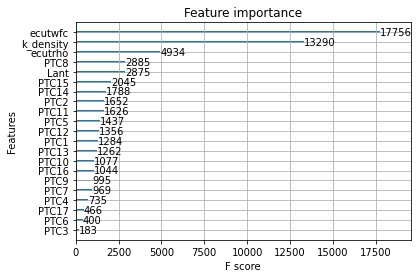

In [28]:
xgb.plot_importance(xgb_model)

### $\log(\Delta E)$

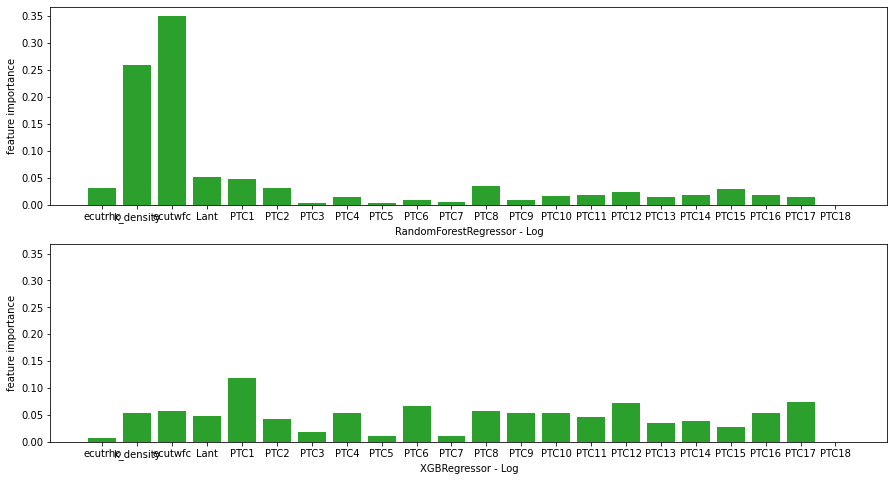

In [29]:
# plot feature importance
models_log_feature_importance = {
    "RandomForestRegressor - Log": rf_log_model,
    "XGBRegressor - Log": xgb_log_model,
}
n_models_log = len(models_log_feature_importance)
fig, ax = plt.subplots(n_models_log, 1,figsize=(15,4*n_models_log), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models_log_feature_importance.items()):
    ax[j,0].bar(X_train.columns, model.feature_importances_)
    ax[j,0].bar(X_test.columns, model.feature_importances_)
    ax[j,0].bar(X_test.columns, model.feature_importances_)
    ax[j,0].set_ylabel("feature importance")
    ax[j,0].set_xlabel(name)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

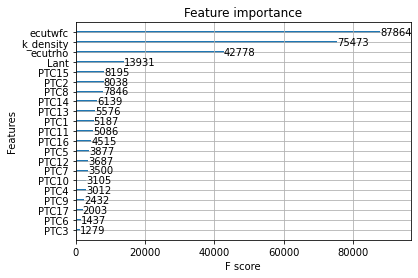

In [30]:
xgb.plot_importance(xgb_log_model)

# Compare $\Delta E$ and $\log(\Delta E)$ predictions

In [31]:
n_sample = 20
idx_sample = np.random.choice(X_test.shape[0], n_sample, replace=False)
df_pred_samples = pd.DataFrame(index=np.arange(n_sample))
df_pred_samples["real"] = np.array(y_test).squeeze()[idx_sample]

for name, model in models.items():
    df_pred_samples[name] = model.predict(X_test)[idx_sample]

for name, model in models_log.items():
    df_pred_samples[name] = log_transform.inverse_transform(model.predict(X_test)[idx_sample])

pd.set_option('display.float_format', '{:.3E}'.format)
df_pred_samples

,real,Augmented Linear Regression,Random Forest,XGBoost,Augmented Linear Regression - Log,Random Forest - Log,XGBoost - Log
0,3.080E-01,1.792E-01,3.080E-01,3.043E-01,1.991E-02,3.080E-01,3.118E-01
1,8.776E-03,1.144E-01,8.779E-03,7.836E-03,9.315E-03,8.775E-03,9.927E-03
2,4.232E-01,2.874E-01,4.232E-01,4.197E-01,3.329E-01,4.232E-01,4.050E-01
3,1.183E+00,3.553E-01,1.183E+00,1.185E+00,1.768E-01,1.183E+00,1.252E+00
4,2.227E-05,-1.675E-02,2.279E-05,9.388E-05,3.181E-05,2.319E-05,2.191E-05
5,1.668E-02,-9.228E-03,1.668E-02,1.692E-02,6.852E-03,1.668E-02,1.729E-02
6,1.860E-02,2.368E-01,1.851E-02,2.416E-02,8.778E-02,1.888E-02,1.856E-02
7,6.232E-05,-2.884E-02,7.010E-05,-3.671E-04,8.266E-05,6.515E-05,5.912E-05
8,4.318E-04,9.565E-02,4.084E-04,1.866E-03,3.251E-03,4.294E-04,4.530E-04
9,7.505E-02,1.187E-01,7.272E-02,7.240E-02,2.727E-02,7.622E-02,8.463E-02


# Find best parameters for a given error

In [32]:
from scipy.optimize import NonlinearConstraint, LinearConstraint, minimize, shgo, differential_evolution

In [33]:
def sanitize_input(x):
    return np.array([int(round(x_i)) for x_i in x])

def delta_E_prediction(x, model, structure_encoding):
    input = np.concatenate([x, structure_encoding])
    input = pd.DataFrame(input.reshape(1, -1), columns=X_raw.columns)
    return model.predict(input)[0]

def complexity(x):
    # we have to get the right formula for the complexity
    ecutrho = x[0]
    k_density = x[1]
    ecutwfc = x[2]
    return ecutrho + k_density + ecutwfc

In [34]:
# # Compute GeTe structure encoding
# first load GeTe dataset
GeTe_data = df[df["structure"] == "GeTe"]

# then find the index of the first encoding column
if encoding in [Encoding.COLUMN, Encoding.COLUMN_MASS]:
    enc_first_idx = next((i for i, col in enumerate(GeTe_data.columns) if col in PTC_COLNAMES), None)
elif encoding == Encoding.ATOMIC:
    enc_first_idx = next((i for i, col in enumerate(GeTe_data.columns) if col in PERIODIC_TABLE_INFO), None)

# finally get the encoding
GeTe_encoding = np.array(GeTe_data.iloc[0, enc_first_idx:].values, dtype=float)

### Minimize complexity using $\Delta E$ regressors

In [35]:
x_0 = [100, 10, 100]
max_delta_E = 1e-3
model = xgb_model
model_pred_func = lambda x: delta_E_prediction(x, model, GeTe_encoding)

nonlin_constraint = NonlinearConstraint(lambda x: delta_E_prediction(x, model), 0, max_delta_E)
# lin_constraint = LinearConstraint(A=np.eye(3), lb=np.array([1,0,1]), ub=np.array([1000,0.5,1000]))

print(model_pred_func(x_0))

mu = 1e100
pen_func = lambda x: complexity(x) + mu * max(model_pred_func(x) - max_delta_E, 0) / max_delta_E
res = differential_evolution(
    pen_func,
    bounds=[
        (X_raw["ecutrho"].min(),X_raw["ecutrho"].max()), 
        (X_raw["k_density"].min(), X_raw["k_density"].max()),
        (X_raw["ecutwfc"].min(),X_raw["ecutwfc"].max())
    ],
    seed=0,
)

print(res)
print(sanitize_input(res.x))

print(model_pred_func(res.x))

# codes below don't work

# minimize(complexity, x_0, constraints=[nonlin_constraint, lin_constraint])

# res = minimize(complexity, x0=x_0, bounds=[(1,1000), (1e-16,0.5), (1,1000)],
#     constraints=({'type': 'ineq', 'fun': lambda x: delta_E_prediction(x, model)},
#                  {'type': 'ineq', 'fun': lambda x: -delta_E_prediction(x, model) + max_delta_E}),
#     options={'maxiter': 1000},
# )


0.009748161
     fun: 4.978680610656736e+98
 message: 'Optimization terminated successfully.'
    nfev: 634
     nit: 13
 success: True
       x: array([350.78986458,   5.08269572,  96.27216932])
[351   5  96]
0.0010497868


### Minimize complexity using $log(\Delta E)$ regressors

In [36]:
max_delta_E = 1e-5
model_log = xgb_log_model
model_log_pred_func = lambda x: log_transform.inverse_transform(delta_E_prediction(x, model_log, GeTe_encoding))

mu = 1e100
pen_func = lambda x: complexity(x) + mu * max(model_log_pred_func(x) - max_delta_E, 0) / max_delta_E
res = differential_evolution(
    pen_func,
    bounds=[
        (X_raw["ecutrho"].min(),X_raw["ecutrho"].max()), 
        (X_raw["k_density"].min(), X_raw["k_density"].max()),
        (X_raw["ecutwfc"].min(),X_raw["ecutwfc"].max())
    ],
    seed=0,
)

print(res)
print(sanitize_input(res.x))

print(model_log_pred_func(res.x))

     fun: 234.28254414736665
 message: 'Optimization terminated successfully.'
    nfev: 1362
     nit: 29
 success: True
       x: array([140.09685549,   4.00765351,  90.17803515])
[140   4  90]
3.182105950827463e-06


### Compare predicted parameters to the ones in datasets

In [37]:
from sklearn.neighbors import NearestNeighbors

In [38]:
def find_neighbors(X, y, params, structure_encoding):
    # TODO define a good distance metric for params
    
    n_params = len(params)

    # get all rows with the same structure
    mask_same_struct = (X.values[:,n_params:] == structure_encoding).all(axis=1)
    df_same_struct = X.iloc[mask_same_struct,:n_params]
    y_same_struct = y[mask_same_struct]

    # normalize the dataset in order to put the same importance to all parameters
    min_df, max_df = df_same_struct.min(), df_same_struct.max()
    df_same_struct = (df_same_struct - min_df) / (max_df - min_df)
    params = (params - min_df) / (max_df - min_df)

    knn = NearestNeighbors(n_neighbors=10, algorithm='auto')
    knn.fit(df_same_struct)
    dist, idx = knn.kneighbors([params], 10)
    list_dist_delta_E = [*zip(dist[0], list(y_same_struct.iloc[idx[0]]))]
    return pd.DataFrame(list_dist_delta_E, columns=["dist", "delta_E"])

In [39]:
find_neighbors(X_raw, y_raw, sanitize_input(res.x), GeTe_encoding)

,dist,delta_E
0,0.000E+00,4.330E-06
1,7.143E-02,8.914E-05
2,1.429E-01,4.340E-06
3,1.429E-01,1.239E-04
4,1.597E-01,9.721E-05
5,2.020E-01,1.317E-04
6,2.020E-01,1.312E-02
7,2.143E-01,1.276E-04
8,2.500E-01,1.646E-03
9,2.500E-01,1.481E-01


# Testing model generalization on unseen structures

In [40]:
# find the index of the first encoding column
if encoding in ["column", "column_mass"]:
    enc_first_idx = next((i for i, col in enumerate(df.columns) if "PTC" in col), None)
elif encoding == "atomic":
    enc_first_idx = next((i for i, col in enumerate(df.columns) if col in PERIODIC_TABLE_INFO), None)

In [41]:
# # selecting species for training and testing
p = 0.2

# col_max_nonzero = df.columns[enc_first_idx + np.argmax(np.count_nonzero(df.iloc[:, enc_first_idx:], axis=0))]
# species_col_max = df[df[col_max_nonzero] > 0]["structure"].unique()
# species_test_set = np.random.choice(species_col_max, size=int(p*len(species_col_max)))

species_test_set = np.random.choice(df["structure"].unique(), size=int(p*len(df["structure"].unique())))

species_train_set = [s for s in df["structure"].unique() if s not in species_test_set]

In [42]:
X_train_gen = df[df["converged"]][df["structure"].isin(species_train_set)][cols_dependent]
y_train_gen = np.abs(df[df["converged"]][df["structure"].isin(species_train_set)][cols_independent]).squeeze()
logy_train_gen = log_transform.transform(np.abs(df[df["converged"]][df["structure"].isin(species_train_set)][cols_independent]).squeeze())
X_test_gen = df[df["converged"]][df["structure"].isin(species_test_set)][cols_dependent]
y_test_gen = np.abs(df[df["converged"]][df["structure"].isin(species_test_set)][cols_independent]).squeeze()
logy_test_gen = log_transform.transform(np.abs(df[df["converged"]][df["structure"].isin(species_test_set)][cols_independent]).squeeze())

In [43]:
rf_model_gen = RandomForestRegressor(random_state=0)
xgb_model_gen = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0, tree_method="gpu_hist")
rf_model_gen_log = RandomForestRegressor(random_state=0)
xgb_model_gen_log = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0, tree_method="gpu_hist")

In [44]:
models_gen = {
    "Random Forest - Gen": rf_model_gen,
    "XGBoost - Gen": xgb_model_gen,
}
models_gen_log = {
    "Random Forest - Log - Gen": rf_model_gen_log,
    "XGBoost - Log - Gen": xgb_model_gen_log,
}

In [45]:
for model_name, model in models_gen.items():
    print(f"Training {model_name}...")
    model.fit(X_train_gen, y_train_gen)
    print("Done!\n")

Training Random Forest - Gen...
Done!

Training XGBoost - Gen...
Done!



In [46]:
for model_name, model in models_gen_log.items():
    print(f"Training {model_name}...")
    model.fit(X_train_gen, logy_train_gen)
    print("Done!\n")

Training Random Forest - Log - Gen...
Done!

Training XGBoost - Log - Gen...
Done!



In [47]:
for model_name, model in models_gen.items():
    print(f"Evaluating {model_name}...")

    y_pred_train = model.predict(X_train_gen)
    y_pred_test = model.predict(X_test_gen)

    mse_test = mean_squared_error(y_test_gen, y_pred_test)
    mse_train = mean_squared_error(y_train_gen, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mape_test = mean_absolute_percentage_error(y_test_gen, y_pred_test)
    mape_train = mean_absolute_percentage_error(y_train_gen, y_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Random Forest - Gen...
MSE:	train:7.9112E-07	test:5.4552E-03
MAPE:	train:2.0261E+08	test:3.9668E+10
Done!

Evaluating XGBoost - Gen...
MSE:	train:5.0880E-06	test:7.4134E-03
MAPE:	train:5.7660E+09	test:1.4583E+11
Done!



In [48]:
for model_name, model in models_gen_log.items():
    print(f"Evaluating {model_name}...")

    logy_pred_train = model.predict(X_train_gen)
    y_pred_train = log_transform.inverse_transform(logy_pred_train.squeeze())
    logy_pred_test = model.predict(X_test_gen)
    y_pred_test = log_transform.inverse_transform(logy_pred_test.squeeze())
    
    mse_test = mean_squared_error(logy_test_gen, logy_pred_test)
    mse_train = mean_squared_error(logy_train_gen, logy_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")
    
    mse_test = mean_squared_error(y_test_gen, y_pred_test)
    mse_train = mean_squared_error(y_train_gen, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mape_test = mean_absolute_percentage_error(logy_test_gen, logy_pred_test)
    mape_train = mean_absolute_percentage_error(logy_train_gen, logy_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Random Forest - Log - Gen...
MSE:	train:2.4224E-02	test:5.5602E+00
MSE:	train:6.3093E-06	test:3.6624E-03
MAPE:	train:4.0388E-03	test:2.9591E-01
Done!

Evaluating XGBoost - Log - Gen...
MSE:	train:4.1365E-02	test:4.0247E+00
MSE:	train:1.5632E-04	test:6.9757E-03
MAPE:	train:2.1621E-02	test:3.0130E-01
Done!



## Compare $\Delta E$ and $\log(\Delta E)$ predictions

In [49]:
n_sample = 20
idx_sample = np.random.choice(X_test_gen.shape[0], n_sample, replace=False)
df_pred_samples = pd.DataFrame(index=np.arange(n_sample))
df_pred_samples["real"] = np.array(y_test_gen).squeeze()[idx_sample]

for name, model in models_gen.items():
    df_pred_samples[name] = model.predict(X_test_gen)[idx_sample]

for name, model in models_gen_log.items():
    df_pred_samples[name] = log_transform.inverse_transform(model.predict(X_test_gen)[idx_sample])

pd.set_option('display.float_format', '{:.3E}'.format)
df_pred_samples

,real,Random Forest - Gen,XGBoost - Gen,Random Forest - Log - Gen,XGBoost - Log - Gen
0,3.864E-03,2.801E-03,9.792E-04,4.822E-03,3.456E-03
1,9.507E-02,5.783E-02,5.089E-02,5.302E-02,6.162E-02
2,9.017E-03,2.451E-02,3.338E-02,2.381E-02,3.651E-02
3,6.763E-02,1.128E-06,5.569E-02,4.779E-09,1.157E-02
4,4.848E-03,4.104E-03,2.714E-02,4.168E-03,2.359E-03
5,1.022E-04,3.413E-03,6.580E-04,3.910E-03,1.304E-03
6,6.971E-05,7.867E-05,1.379E-03,7.386E-05,3.457E-05
7,7.885E-03,7.671E-04,6.518E-03,7.585E-04,9.771E-04
8,6.643E-02,1.627E-02,1.684E-02,2.400E-05,1.434E-02
9,4.229E-03,5.787E-02,2.398E-02,1.343E-02,7.223E-04
